In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder,StandardScaler,PowerTransformer, MinMaxScaler, RobustScaler
from sklearn.model_selection import KFold, cross_val_predict, train_test_split,GridSearchCV,cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression, Lasso, Ridge,ElasticNet
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve, roc_auc_score, auc, roc_curve, average_precision_score, precision_recall_curve
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix, log_loss, recall_score, accuracy_score, precision_score, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.feature_selection import SelectKBest,SelectPercentile,f_classif,f_regression,mutual_info_regression
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.impute import SimpleImputer
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.cluster import KElbowVisualizer
from sklearn.ensemble import RandomForestClassifier

import missingno as msno

#importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (10,6)
pd.set_option('max_colwidth',200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', lambda x: '%.7f' % x)

# User Defined Functions

In [24]:
# For checking missing values and missing percent

def missing (df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values

In [25]:
# To view summary information about the column

def first_looking(col):
    print("column name    : ", col)
    print("--------------------------------")
    print("per_of_nulls   : ", "%", round(df[col].isnull().sum()/df.shape[0]*100, 2))
    print("num_of_nulls   : ", df[col].isnull().sum())
    print("num_of_uniques : ", df[col].nunique())
    print(df[col].value_counts(dropna = False))

In [26]:
# For getting the scores

def train_val(y_train, y_train_pred, y_test, y_pred):
    
    scores = {"train_set": {"Accuracy" : accuracy_score(y_train, y_train_pred),
                            "Precision" : precision_score(y_train, y_train_pred),
                            "Recall" : recall_score(y_train, y_train_pred),                          
                            "f1" : f1_score(y_train, y_train_pred)},
    
              "test_set": {"Accuracy" : accuracy_score(y_test, y_pred),
                           "Precision" : precision_score(y_test, y_pred),
                           "Recall" : recall_score(y_test, y_pred),                          
                           "f1" : f1_score(y_test, y_pred)}}
    
    return pd.DataFrame(scores)

# Data Gathering

In [27]:
# df = pd.read_csv("../input/water-potability/water_potability.csv")
# df.head()

In [28]:
df = pd.read_csv("water_potability.csv")

# Data Preparation

In [29]:
df.head()

ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0       NaN 204.8904555 20791.3189807    7.3002119 368.5164413   564.3086542   
1 3.7160801 129.4229205 18630.0578580    6.6352459         NaN   592.8853591   
2 8.0991242 224.2362594 19909.5417323    9.2758836         NaN   418.6062131   
3 8.3167659 214.3733941 22018.4174408    8.0593324 356.8861356   363.2665162   
4 9.0922235 181.1015092 17978.9863389    6.5466000 310.1357375   398.4108134   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0      10.3797831       86.9909705  2.9631354           0  
1      15.1800131       56.3290763  4.5006563           0  
2      16.8686369       66.4200925  3.0559337           0  
3      18.4365245      100.3416744  4.6287705           0  
4      11.5582794       31.9979927  4.0750754           0

In [30]:
df.tail()

ph    Hardness        Solids  Chloramines     Sulfate  \
3271 4.6681017 193.6817355 47580.9916033    7.1666389 359.9485744   
3272 7.8088560 193.5532116 17329.8021601    8.0613620         NaN   
3273 9.4195103 175.7626463 33155.5782183    7.3502332         NaN   
3274 5.1267629 230.6037575 11983.8693763    6.3033565         NaN   
3275 7.8746714 195.1022986 17404.1770611    7.5093059         NaN   

      Conductivity  Organic_carbon  Trihalomethanes  Turbidity  Potability  
3271   526.4241709      13.8944185       66.6876948  4.4358209           1  
3272   392.4495796      19.9032252              NaN  2.7982428           1  
3273   432.0447830      11.0390697       69.8454003  3.2988755           1  
3274   402.8831131      11.1689462       77.4882131  4.7086585           1  
3275   327.4597605      16.1403676       78.6984463  2.3091491           1

In [31]:
df.sample(10)

ph    Hardness        Solids  Chloramines     Sulfate  \
979  8.1630764 183.1618528 20335.6765096    6.0285594 333.0844548   
2245 5.1662260 135.7121661 12060.0095272    8.6370979         NaN   
1428 8.2683076 168.6878903 13181.6735161    6.3832261 298.3070931   
236  5.7796737 199.5860803 24160.3543210    9.4581283         NaN   
1144 5.7445042 208.0700518 19457.6394811    6.6939494         NaN   
369  6.9525117 211.6972974 33737.2885243    6.3008707         NaN   
2500       NaN 202.5694674 22256.9503646    6.9135005 304.9514981   
1443       NaN 196.1393118 10540.3422778    6.4594597 359.1687216   
1351 8.6474540 183.5973743 12995.8854275    6.1954491 382.3578688   
2871 6.9777441 166.8455743 18622.4447956    6.6097062 353.3399191   

      Conductivity  Organic_carbon  Trihalomethanes  Turbidity  Potability  
979    475.2964708      18.2480979       49.6048424  3.2872440           0  
2245   362.2172579      11.1855539       76.0670638  4.6083194           0  
1428   294.2980647      12.3664244       79.2064733  4.4054082           0  
236    428.5532485      16.0225032       64.8727034  4.6563772           0  
1144   362.0624898      15.6037293       82.3178540  3.5335001           1  
369    395.4070038      14.1823961       39.8029071  4.1054955           1  
2500   434.1984358      13.6968931       64.2056667  4.4780705           0  
1443   400.6796021      13.5835593       45.9007058  4.1494833           0  
1351   489.7627989      18.0769635       93.4096136  3.6241007           0  
2871   333.9685677      12.5345600       48.4635884  3.5306227           0

In [32]:
df.columns

Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability'],
      dtype='object')

In [33]:
df.columns = df.columns.str.lower().str.replace('&', '_').str.replace(' ', '_')

In [34]:
df.columns

Index(['ph', 'hardness', 'solids', 'chloramines', 'sulfate', 'conductivity',
       'organic_carbon', 'trihalomethanes', 'turbidity', 'potability'],
      dtype='object')

In [35]:
print("There is", df.shape[0], "observation and", df.shape[1], "columns in the dataset")

There is 3276 observation and 10 columns in the dataset


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   hardness         3276 non-null   float64
 2   solids           3276 non-null   float64
 3   chloramines      3276 non-null   float64
 4   sulfate          2495 non-null   float64
 5   conductivity     3276 non-null   float64
 6   organic_carbon   3276 non-null   float64
 7   trihalomethanes  3114 non-null   float64
 8   turbidity        3276 non-null   float64
 9   potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [37]:
df.describe().T

count          mean          std         min  \
ph              2785.0000000     7.0807945    1.5943195   0.0000000   
hardness        3276.0000000   196.3694960   32.8797615  47.4320000   
solids          3276.0000000 22014.0925261 8768.5708278 320.9426113   
chloramines     3276.0000000     7.1222768    1.5830849   0.3520000   
sulfate         2495.0000000   333.7757766   41.4168405 129.0000000   
conductivity    3276.0000000   426.2051107   80.8240641 181.4837540   
organic_carbon  3276.0000000    14.2849702    3.3081620   2.2000000   
trihalomethanes 3114.0000000    66.3962929   16.1750084   0.7380000   
turbidity       3276.0000000     3.9667862    0.7803824   1.4500000   
potability      3276.0000000     0.3901099    0.4878492   0.0000000   

                          25%           50%           75%           max  
ph                  6.0930919     7.0367521     8.0620661    14.0000000  
hardness          176.8505379   196.9676269   216.6674562   323.1240000  
solids          15666.6902970 20927.8336065 27332.7621274 61227.1960077  
chloramines         6.1274208     7.1302990     8.1148870    13.1270000  
sulfate           307.6994978   333.0735457   359.9501704   481.0306423  
conductivity      365.7344141   421.8849683   481.7923045   753.3426196  
organic_carbon     12.0658013    14.2183379    16.5576515    28.3000000  
trihalomethanes    55.8445356    66.6224851    77.3374729   124.0000000  
turbidity           3.4397109     3.9550276     4.5003198     6.7390000  
potability          0.0000000     0.0000000     1.0000000     1.0000000

In [38]:
df.nunique()

ph                 2785
hardness           3276
solids             3276
chloramines        3276
sulfate            2495
conductivity       3276
organic_carbon     3276
trihalomethanes    3114
turbidity          3276
potability            2
dtype: int64

In [70]:
# to find how many unique values object features have
for col in df.select_dtypes(include=[np.number]).columns:
  print(f"{col} has {df[col].nunique()} unique value")

ph has 2785 unique value
hardness has 3276 unique value
solids has 3276 unique value
chloramines has 3276 unique value
sulfate has 2495 unique value
conductivity has 3276 unique value
organic_carbon has 3276 unique value
trihalomethanes has 3114 unique value
turbidity has 3276 unique value
potability has 2 unique value


In [39]:
missing (df)

Missing_Number  Missing_Percent
sulfate                     781        0.2384005
ph                          491        0.1498779
trihalomethanes             162        0.0494505
hardness                      0        0.0000000
solids                        0        0.0000000
chloramines                   0        0.0000000
conductivity                  0        0.0000000
organic_carbon                0        0.0000000
turbidity                     0        0.0000000
potability                    0        0.0000000

In [67]:
drop_list =[]
for col in df.columns:
  if df[col].isnull().sum()>100:
    print(f"{col} = {df[col].isnull().sum()}")
    drop_list.append(col)
  
  
drop_list 

ph = 491
sulfate = 781
trihalomethanes = 162


['ph', 'sulfate', 'trihalomethanes']

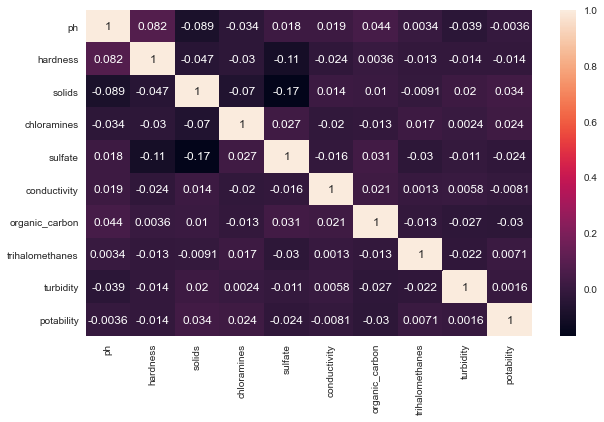

In [40]:
sns.heatmap(df.corr(), annot=True);

### The Examination of Target Variable

In [41]:
first_looking("potability")

column name    :  potability
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  2
0    1998
1    1278
Name: potability, dtype: int64


0    1998
1    1278
Name: potability, dtype: int64


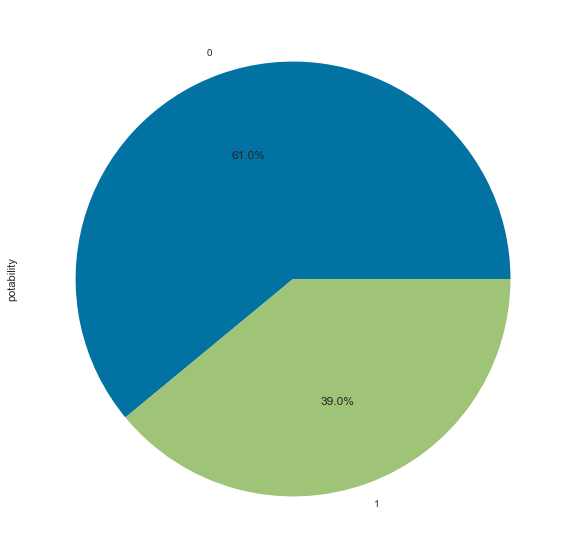

In [72]:
print(df["potability"].value_counts())
df["potability"].value_counts().plot(kind="pie", autopct='%1.1f%%',figsize=(10,10));

In [42]:
df['potability'].describe()

count   3276.0000000
mean       0.3901099
std        0.4878492
min        0.0000000
25%        0.0000000
50%        0.0000000
75%        1.0000000
max        1.0000000
Name: potability, dtype: float64

In [43]:
print( f"Skewness: {df['potability'].skew()}")

Skewness: 0.4507837491078628


In [50]:
df['potability'].iplot(kind='hist')

In [51]:
# numerical= df.drop(['potability'], axis=1).select_dtypes('number').columns

# categorical = df.select_dtypes('object').columns

# print(f'Numerical Columns:  {df[numerical].columns}')
# print('\n')
# print(f'Categorical Columns: {df[categorical].columns}')

Numerical Columns:  Index(['ph', 'hardness', 'solids', 'chloramines', 'sulfate', 'conductivity',
       'organic_carbon', 'trihalomethanes', 'turbidity'],
      dtype='object')


Categorical Columns: Index([], dtype='object')


In [52]:
df[numerical].head().T

0             1             2             3  \
ph                        NaN     3.7160801     8.0991242     8.3167659   
hardness          204.8904555   129.4229205   224.2362594   214.3733941   
solids          20791.3189807 18630.0578580 19909.5417323 22018.4174408   
chloramines         7.3002119     6.6352459     9.2758836     8.0593324   
sulfate           368.5164413           NaN           NaN   356.8861356   
conductivity      564.3086542   592.8853591   418.6062131   363.2665162   
organic_carbon     10.3797831    15.1800131    16.8686369    18.4365245   
trihalomethanes    86.9909705    56.3290763    66.4200925   100.3416744   
turbidity           2.9631354     4.5006563     3.0559337     4.6287705   

                            4  
ph                  9.0922235  
hardness          181.1015092  
solids          17978.9863389  
chloramines         6.5466000  
sulfate           310.1357375  
conductivity      398.4108134  
organic_carbon     11.5582794  
trihalomethanes    31.9979927  
turbidity           4.0750754

In [53]:
df[numerical].describe().T

count          mean          std         min  \
ph              2785.0000000     7.0807945    1.5943195   0.0000000   
hardness        3276.0000000   196.3694960   32.8797615  47.4320000   
solids          3276.0000000 22014.0925261 8768.5708278 320.9426113   
chloramines     3276.0000000     7.1222768    1.5830849   0.3520000   
sulfate         2495.0000000   333.7757766   41.4168405 129.0000000   
conductivity    3276.0000000   426.2051107   80.8240641 181.4837540   
organic_carbon  3276.0000000    14.2849702    3.3081620   2.2000000   
trihalomethanes 3114.0000000    66.3962929   16.1750084   0.7380000   
turbidity       3276.0000000     3.9667862    0.7803824   1.4500000   

                          25%           50%           75%           max  
ph                  6.0930919     7.0367521     8.0620661    14.0000000  
hardness          176.8505379   196.9676269   216.6674562   323.1240000  
solids          15666.6902970 20927.8336065 27332.7621274 61227.1960077  
chloramines         6.1274208     7.1302990     8.1148870    13.1270000  
sulfate           307.6994978   333.0735457   359.9501704   481.0306423  
conductivity      365.7344141   421.8849683   481.7923045   753.3426196  
organic_carbon     12.0658013    14.2183379    16.5576515    28.3000000  
trihalomethanes    55.8445356    66.6224851    77.3374729   124.0000000  
turbidity           3.4397109     3.9550276     4.5003198     6.7390000

In [73]:
for col in df.select_dtypes(include=[np.number]).columns:
    if df[col].min() == 0:
        print(col)

ph
potability


In [75]:
df["ph"].argmin()

3014

In [54]:
# df[numerical].iplot(kind='hist');

In [55]:
# df[numerical].iplot(kind='histogram',subplots=True,bins=50)

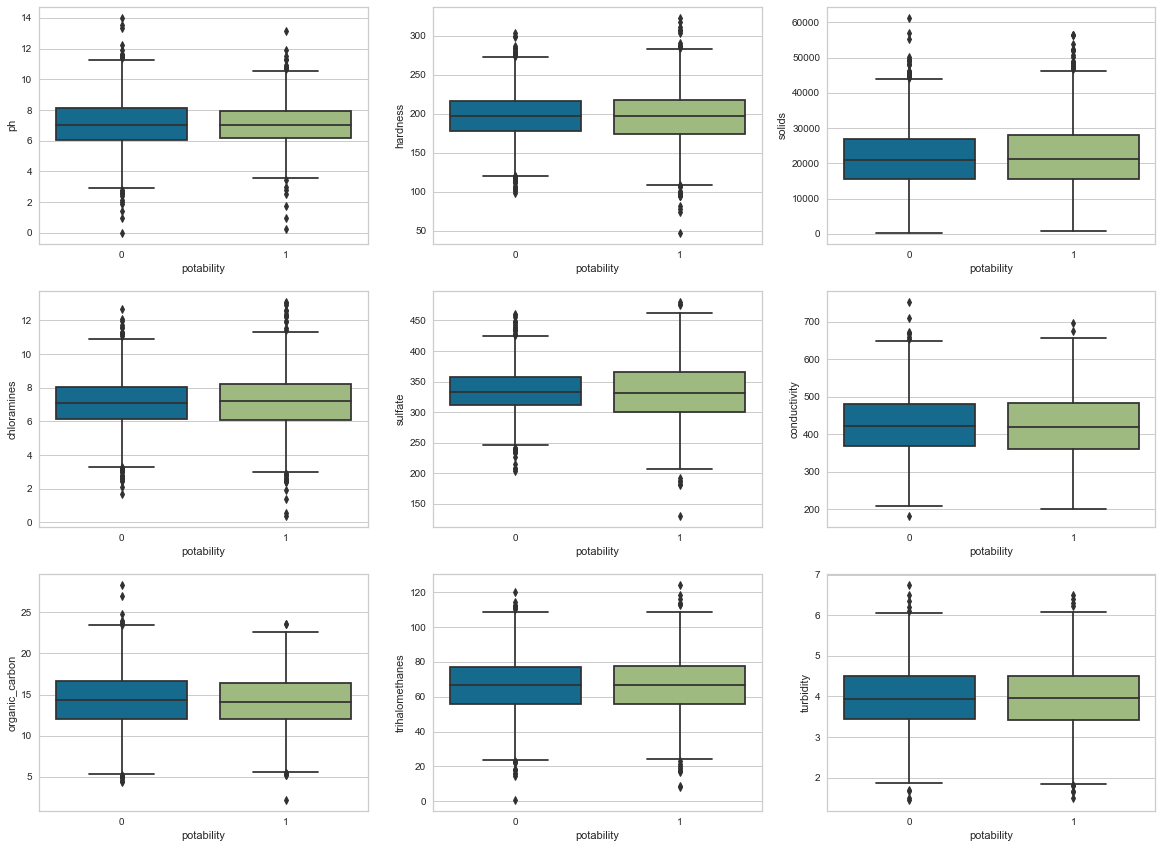

In [56]:
index = 0
plt.figure(figsize=(20,20))
for feature in numerical:
    if feature != "potability":
        index += 1
        plt.subplot(4,3,index)
        sns.boxplot(x='potability',y=feature,data=df)

In [26]:
# skew_limit = 0.75 # This is our threshold-limit to evaluate skewness. Overall below abs(1) seems acceptable for the linear models. 
# skew_vals = df[numerical].skew()
# skew_cols = skew_vals[abs(skew_vals)> skew_limit].sort_values(ascending=False)
# skew_cols 

Series([], dtype: float64)

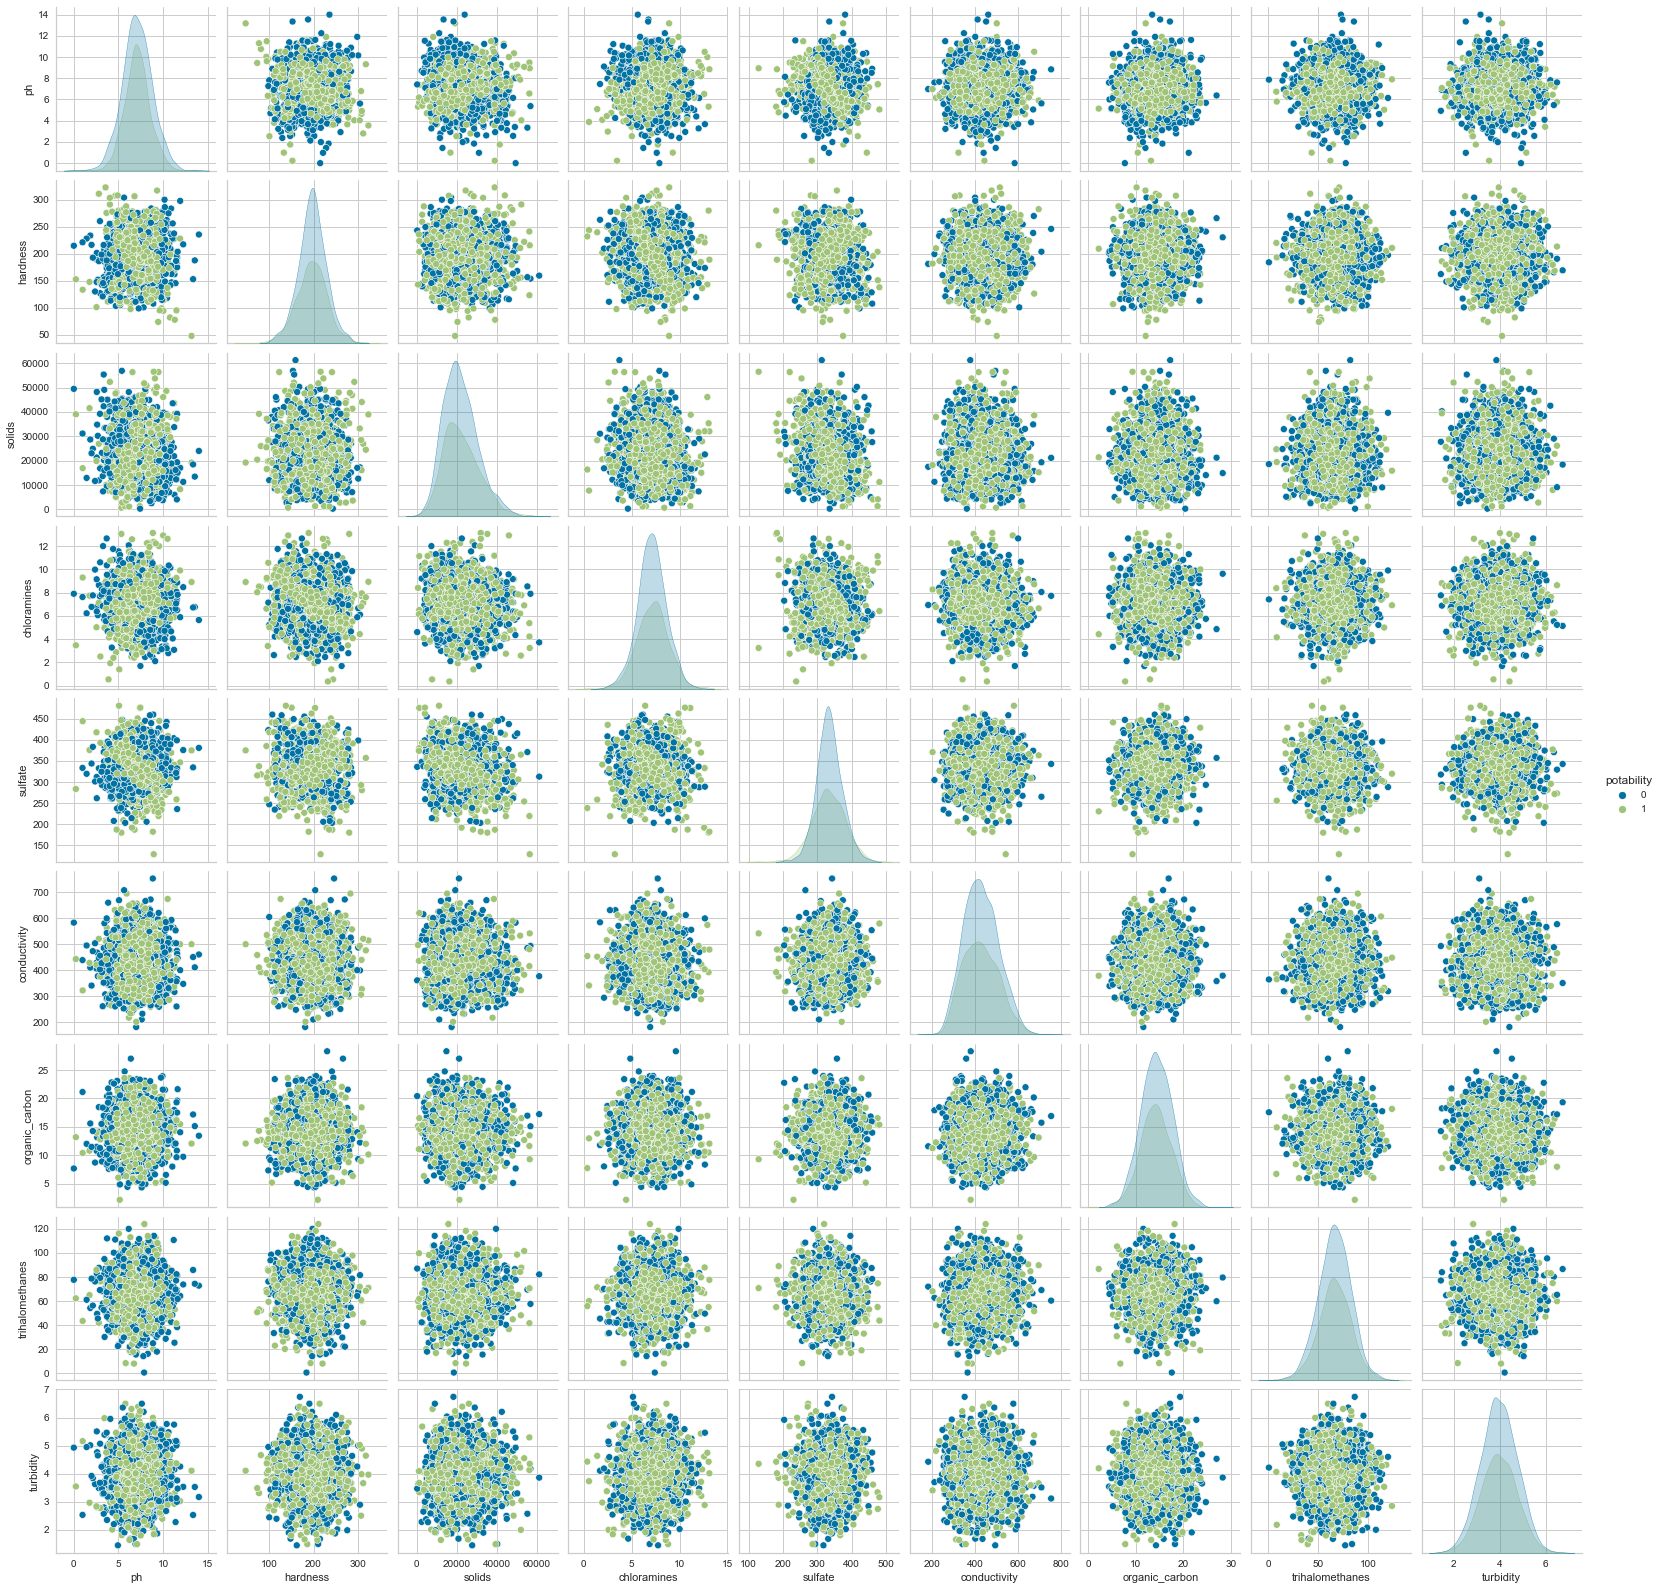

In [58]:
# sns.pairplot(df, hue="potability");

# Data Preprocessing

In [28]:
X = df.drop('potability',axis=1)
y = df['potability']

### Train / Test and Split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Filling the Missing Values

In [30]:
X.isnull().sum()

ph                 491
hardness             0
solids               0
chloramines          0
sulfate            781
conductivity         0
organic_carbon       0
trihalomethanes    162
turbidity            0
dtype: int64

In [31]:
imputer = SimpleImputer(missing_values=np.nan, strategy="mean")

X_train['ph'] = imputer.fit_transform(X_train['ph'].values.reshape(-1,1))[:,0]

In [32]:
X_test['ph'] = imputer.transform(X_test['ph'].values.reshape(-1,1))[:,0]

In [33]:
X_train['sulfate'] = imputer.fit_transform(X_train['sulfate'].values.reshape(-1,1))[:,0]

In [34]:
X_test['sulfate'] = imputer.transform(X_test['sulfate'].values.reshape(-1,1))[:,0]

In [35]:
X_train['trihalomethanes'] = imputer.fit_transform(X_train['trihalomethanes'].values.reshape(-1,1))[:,0]

In [36]:
X_test['trihalomethanes'] = imputer.transform(X_test['trihalomethanes'].values.reshape(-1,1))[:,0]

In [37]:
print(X_train.isnull().sum())

ph                 0
hardness           0
solids             0
chloramines        0
sulfate            0
conductivity       0
organic_carbon     0
trihalomethanes    0
turbidity          0
dtype: int64


In [38]:
print(X_train.isnull().sum())

ph                 0
hardness           0
solids             0
chloramines        0
sulfate            0
conductivity       0
organic_carbon     0
trihalomethanes    0
turbidity          0
dtype: int64


### Scaling

In [39]:
scaler = MinMaxScaler()
scaler

MinMaxScaler()

In [40]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Implement Logistic Regression and Evaluate

### Model Performance

In [50]:
log_model=LogisticRegression(class_weight = "balanced")
log_model.fit(X_train_scaled, y_train)
y_pred=log_model.predict(X_test_scaled)
y_pred_proba = log_model.predict_proba(X_test_scaled)
y_pred_train = log_model.predict(X_train_scaled)
log_acc = accuracy_score(y_test, y_pred)
log_recall = recall_score(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
train_val(y_train, y_pred_train, y_test, y_pred)

[[279 231]
 [150 159]]
              precision    recall  f1-score   support

           0       0.65      0.55      0.59       510
           1       0.41      0.51      0.45       309

    accuracy                           0.53       819
   macro avg       0.53      0.53      0.52       819
weighted avg       0.56      0.53      0.54       819



train_set  test_set
Accuracy   0.5144485 0.5347985
Precision  0.4057239 0.4076923
Recall     0.4974200 0.5145631
f1         0.4469170 0.4549356

### Cross Validate

In [43]:
model = LogisticRegression(class_weight = "balanced")

scores = cross_validate(model, X_train, y_train, scoring = ["accuracy", "precision", "recall", "f1"], cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
print(df_scores)
print("--------------------")
print(df_scores.mean()[2:])

    fit_time  score_time  test_accuracy  test_precision  test_recall   test_f1
1  0.0535569   0.0049791      0.4959350       0.3738318    0.4123711 0.3921569
2  0.0890231   0.0000000      0.5000000       0.3796296    0.4226804 0.4000000
3  0.0156467   0.0156004      0.4959350       0.3636364    0.3711340 0.3673469
4  0.0312479   0.0000000      0.4918699       0.3906250    0.5154639 0.4444444
5  0.0468719   0.0000000      0.4959350       0.3865546    0.4742268 0.4259259
6  0.0468774   0.0000000      0.5243902       0.4090909    0.4639175 0.4347826
7  0.0468657   0.0000000      0.4796748       0.3675214    0.4432990 0.4018692
8  0.0312483   0.0000000      0.4938776       0.3793103    0.4583333 0.4150943
9  0.0468705   0.0000000      0.4897959       0.3813559    0.4639175 0.4186047
10 0.0312479   0.0000000      0.4979592       0.3968254    0.5154639 0.4484305
--------------------
test_accuracy    0.4965372
test_precision   0.3828381
test_recall      0.4540808
test_f1          0.4148655
dt

### ROC (Receiver Operating Curve) and AUC (Area Under Curve)

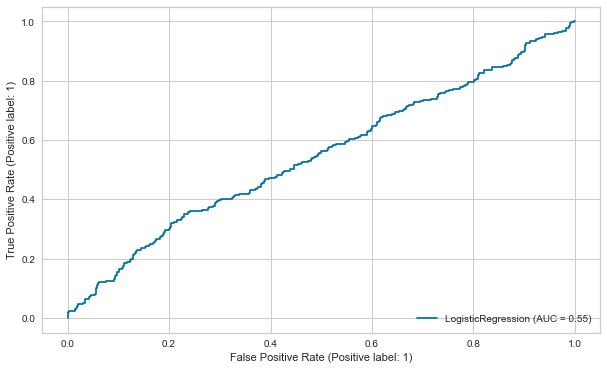

In [44]:
plot_roc_curve(log_model, X_test_scaled, y_test);

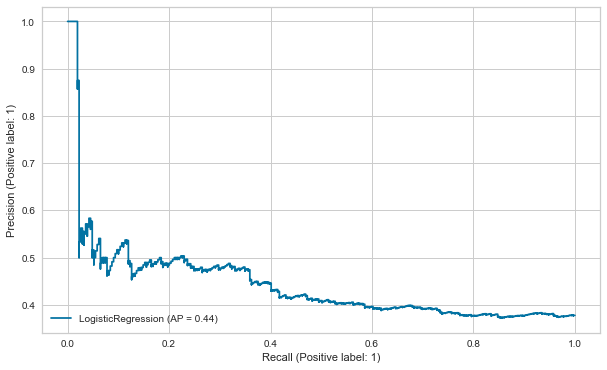

In [45]:
plot_precision_recall_curve(log_model, X_test_scaled, y_test);

### Finding Best Threshold

In [51]:
test_data = pd.concat([X_test, y_test], axis=1)
test_data["pred"] = y_pred
test_data["pred_proba"] = y_pred_proba[:,1]
test_data.sample(10)

ph    hardness        solids  chloramines     sulfate  \
897  10.2006445 182.0806013  8016.2029384    5.5675006 337.7815799   
831   6.6846997 193.8409311 34157.1844736    9.8765741 344.5354072   
1309  7.0911316 173.8167101 26552.9744010    6.2902793 293.1702731   
2581  6.3638364 207.4224363  9844.7022926    9.7659208 320.6307250   
45    5.7029260 216.8504739 35606.4401768    7.1843511 333.9004977   
196   9.8688779 214.1662353 15326.8559141    3.3515978 297.0841735   
1677  6.5854502 166.9659605 30210.2503674    9.5082987 340.2457661   
2596  7.0911316 172.9682028 24445.9875395    7.0326426 333.9004977   
2872  6.3571667 191.1355120 14782.8042214    6.1544479 333.9004977   
1720  5.6212273 221.6494395 11123.8861591    8.8094331 314.8713417   

      conductivity  organic_carbon  trihalomethanes  turbidity  potability  \
897    291.6002828      13.4699240       50.5673721  5.1747198           0   
831    498.0639962       8.8187566       66.6593522  4.0306598           0   
1309   366.7187057      13.2714995       72.1298399  3.2069955           0   
2581   466.5925435      19.1562610       58.2653048  4.0389835           0   
45     504.6382604      16.1407900       77.5361835  4.1377390           0   
196    424.2928308      19.1884414       70.0705141  3.3554898           0   
1677   430.0785909      23.2343259       72.7999174  4.2756402           0   
2596   571.6288923      11.5498773       56.4992072  4.7253475           0   
2872   527.9326364      18.8630944       69.6263250  5.2220773           0   
1720   326.3508725      19.3125363       84.3773232  3.4407533           0   

      pred  pred_proba  
897      0   0.4789214  
831      1   0.5363650  
1309     1   0.5209160  
2581     0   0.4810461  
45       1   0.5070490  
196      0   0.4651134  
1677     0   0.4974722  
2596     1   0.5049322  
2872     0   0.4733966  
1720     0   0.4925977

In [52]:
log_pred_proba = log_model.predict_proba(X_train_scaled)
roc_auc_score(y_train, log_pred_proba[:,1])

0.5215726499994452

In [53]:
fp_rate, tp_rate, thresholds = roc_curve(y_train, log_pred_proba[:,1])

In [54]:
optimal_idx = np.argmax(tp_rate - fp_rate)
optimal_threshold = thresholds[optimal_idx]
optimal_threshold

0.5120265492885842

In [55]:
test_data.head()

ph    hardness        solids  chloramines     sulfate  \
2947 7.0911316 183.5211070 20461.2527102    7.3332122 333.1194759   
2782 6.6431587 188.9135411 32873.8200217    6.7915094 333.8488419   
1644 7.8460579 224.0588768 23264.1099677    5.9223670 300.4026201   
70   7.1604672 183.0893100  6743.3460655    3.8030364 277.5990986   
2045 6.6153501 179.2406613 26392.8636119    9.3091600 333.9004977   

      conductivity  organic_carbon  trihalomethanes  turbidity  potability  \
2947   356.3690224      20.1790289       67.0199032  4.8866338           0   
2782   336.5615010      14.7068103       67.8448489  4.5621977           1   
1644   387.9713358      13.4067375       43.0751865  2.4879686           0   
70     428.0363444       9.7996247       90.0353737  3.8848910           0   
2045   496.3635615      12.7865954       78.2623686  4.4534433           1   

      pred  pred_proba  
2947     0   0.4863334  
2782     1   0.5135902  
1644     0   0.4924927  
70       1   0.5071992  
2045     1   0.5234929

In [56]:
test_data["pred2"] = test_data["pred_proba"].apply(lambda x : 1 if x >= optimal_threshold else 0)

In [57]:
test_data.head()

ph    hardness        solids  chloramines     sulfate  \
2947 7.0911316 183.5211070 20461.2527102    7.3332122 333.1194759   
2782 6.6431587 188.9135411 32873.8200217    6.7915094 333.8488419   
1644 7.8460579 224.0588768 23264.1099677    5.9223670 300.4026201   
70   7.1604672 183.0893100  6743.3460655    3.8030364 277.5990986   
2045 6.6153501 179.2406613 26392.8636119    9.3091600 333.9004977   

      conductivity  organic_carbon  trihalomethanes  turbidity  potability  \
2947   356.3690224      20.1790289       67.0199032  4.8866338           0   
2782   336.5615010      14.7068103       67.8448489  4.5621977           1   
1644   387.9713358      13.4067375       43.0751865  2.4879686           0   
70     428.0363444       9.7996247       90.0353737  3.8848910           0   
2045   496.3635615      12.7865954       78.2623686  4.4534433           1   

      pred  pred_proba  pred2  
2947     0   0.4863334      0  
2782     1   0.5135902      1  
1644     0   0.4924927      0  
70       1   0.5071992      0  
2045     1   0.5234929      1

In [58]:
y_pred2 = test_data["pred2"]

In [63]:
print(confusion_matrix(y_test,y_pred2))
print(classification_report(y_test,y_pred2))
train_val(y_train, y_pred_train, y_test, y_pred2)

[[398 112]
 [207 102]]
              precision    recall  f1-score   support

           0       0.66      0.78      0.71       510
           1       0.48      0.33      0.39       309

    accuracy                           0.61       819
   macro avg       0.57      0.56      0.55       819
weighted avg       0.59      0.61      0.59       819



train_set  test_set
Accuracy   0.5144485 0.6105006
Precision  0.4057239 0.4766355
Recall     0.4974200 0.3300971
f1         0.4469170 0.3900574

In [64]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
train_val(y_train, y_pred_train, y_test, y_pred)

[[279 231]
 [150 159]]
              precision    recall  f1-score   support

           0       0.65      0.55      0.59       510
           1       0.41      0.51      0.45       309

    accuracy                           0.53       819
   macro avg       0.53      0.53      0.52       819
weighted avg       0.56      0.53      0.54       819



train_set  test_set
Accuracy   0.5144485 0.5347985
Precision  0.4057239 0.4076923
Recall     0.4974200 0.5145631
f1         0.4469170 0.4549356

# Implement KNN and Evaluate

### Model Performance

In [80]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_scaled, y_train)
y_pred = knn_model.predict(X_test_scaled)
knn_f1 = f1_score(y_test, y_pred)
knn_recall = recall_score(y_test, y_pred)
knn_auc = roc_auc_score(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[392 118]
 [197 112]]
              precision    recall  f1-score   support

           0       0.67      0.77      0.71       510
           1       0.49      0.36      0.42       309

    accuracy                           0.62       819
   macro avg       0.58      0.57      0.56       819
weighted avg       0.60      0.62      0.60       819



### Elbow Method for Choosing Reasonable K Values

In [81]:
test_error_rates = []


for k in range(1,30):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train_scaled,y_train) 
   
    y_pred_test = knn_model.predict(X_test_scaled)
    
    test_error = 1 - recall_score(y_test,y_pred_test)
    test_error_rates.append(test_error)

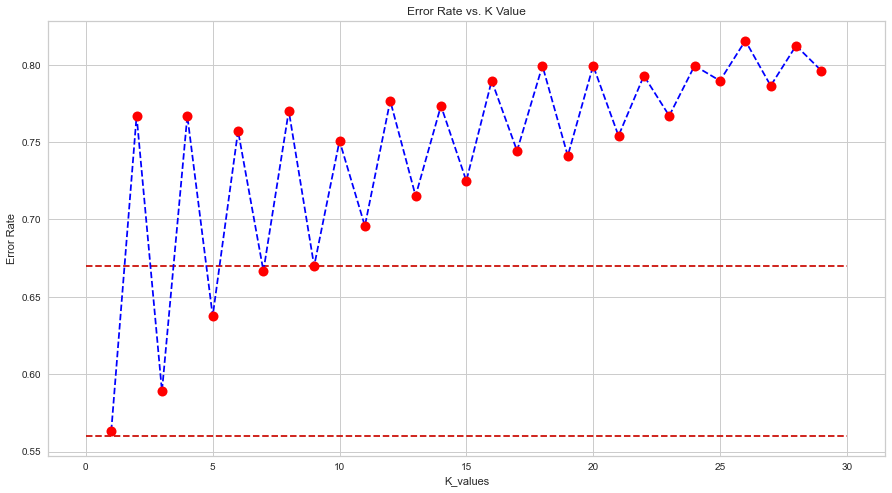

In [82]:
plt.figure(figsize=(15,8))
plt.plot(range(1,30), test_error_rates, color='blue', linestyle='--', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K_values')
plt.ylabel('Error Rate')
plt.hlines(y=0.56, xmin = 0, xmax = 30, colors= 'r', linestyles="--")
plt.hlines(y=0.67, xmin = 0, xmax = 30, colors= 'r', linestyles="--")

In [83]:
knn_model = KNeighborsClassifier(n_neighbors = 1)
knn_model.fit(X_train_scaled, y_train)
y_pred = knn_model.predict(X_test_scaled)
y_pred_train = knn_model.predict(X_train_scaled)
knn_acc = accuracy_score(y_test, y_pred)
knn_recall = recall_score(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
train_val(y_train, y_pred_train, y_test, y_pred)

[[349 161]
 [174 135]]
              precision    recall  f1-score   support

           0       0.67      0.68      0.68       510
           1       0.46      0.44      0.45       309

    accuracy                           0.59       819
   macro avg       0.56      0.56      0.56       819
weighted avg       0.59      0.59      0.59       819



train_set  test_set
Accuracy   1.0000000 0.5909646
Precision  1.0000000 0.4560811
Recall     1.0000000 0.4368932
f1         1.0000000 0.4462810

### Cross Validate

In [84]:
model = KNeighborsClassifier(n_neighbors = 1)

scores = cross_validate(model, X_train_scaled, y_train, scoring = ["accuracy", "precision", "recall", "f1"], cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
print(df_scores)
print("--------------------")
print(df_scores.mean()[2:])

    fit_time  score_time  test_accuracy  test_precision  test_recall   test_f1
1  0.0069947   0.0219884      0.5975610       0.4880952    0.4226804 0.4530387
2  0.0059965   0.0287094      0.5934959       0.4851485    0.5051546 0.4949495
3  0.0089962   0.0220075      0.5569106       0.4333333    0.4020619 0.4171123
4  0.0059969   0.0175889      0.6300813       0.5405405    0.4123711 0.4678363
5  0.0000000   0.0156243      0.5650407       0.4468085    0.4329897 0.4397906
6  0.0000000   0.0312476      0.6260163       0.5294118    0.4639175 0.4945055
7  0.0000000   0.0156226      0.5650407       0.4489796    0.4536082 0.4512821
8  0.0000000   0.0312469      0.6081633       0.5000000    0.5000000 0.5000000
9  0.0000000   0.0156240      0.6122449       0.5104167    0.5051546 0.5077720
10 0.0000000   0.0156236      0.6000000       0.4936709    0.4020619 0.4431818
--------------------
test_accuracy    0.5954555
test_precision   0.4876405
test_recall      0.4500000
test_f1          0.4669469
dt

# Implement SVM and Evaluate

### Model Performance

In [86]:
svm_model = SVC(class_weight = "balanced")
svm_model.fit(X_train_scaled, y_train)
y_pred = svm_model.predict(X_test_scaled)
y_pred_train = svm_model.predict(X_train_scaled)
svm_acc = accuracy_score(y_test, y_pred)
svm_recall = recall_score(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
train_val(y_train, y_pred_train, y_test, y_pred)

[[364 146]
 [151 158]]
              precision    recall  f1-score   support

           0       0.71      0.71      0.71       510
           1       0.52      0.51      0.52       309

    accuracy                           0.64       819
   macro avg       0.61      0.61      0.61       819
weighted avg       0.64      0.64      0.64       819



train_set  test_set
Accuracy   0.7342287 0.6373626
Precision  0.6666667 0.5197368
Recall     0.6522188 0.5113269
f1         0.6593636 0.5154976

### Cross Validate

In [87]:
model = SVC(class_weight = "balanced")

scores = cross_validate(model, X_train_scaled, y_train, scoring = ['accuracy', 'precision','recall','f1'], cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
print(df_scores)
print("--------------------")
print(df_scores.mean()[2:])

    fit_time  score_time  test_accuracy  test_precision  test_recall   test_f1
1  0.3365748   0.0781171      0.6463415       0.5625000    0.4639175 0.5084746
2  0.3281291   0.0624835      0.6382114       0.5425532    0.5257732 0.5340314
3  0.3418541   0.0781162      0.6829268       0.5959596    0.6082474 0.6020408
4  0.3271399   0.0624871      0.6504065       0.5647059    0.4948454 0.5274725
5  0.3124835   0.0624902      0.6341463       0.5376344    0.5154639 0.5263158
6  0.3281112   0.0624847      0.6138211       0.5113636    0.4639175 0.4864865
7  0.3281102   0.0624871      0.6707317       0.5909091    0.5360825 0.5621622
8  0.3124845   0.0624883      0.6448980       0.5517241    0.5000000 0.5245902
9  0.3281107   0.0624859      0.6775510       0.5849057    0.6391753 0.6108374
10 0.3124862   0.0624890      0.6448980       0.5609756    0.4742268 0.5139665
--------------------
test_accuracy    0.6503932
test_precision   0.5603231
test_recall      0.5221649
test_f1          0.5396378
dt

### GridSearch

In [88]:
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': ["scale", "auto", 1, 0.1, 0.01],
              'kernel': ['rbf', 'linear', 'poly'],
              'degree':[2,3,4]}

In [ ]:
model = SVC(class_weight = "balanced")
svm_grid_model = GridSearchCV(model, param_grid, scoring = "f1", n_jobs = -1, verbose = 2).fit(X_train_scaled, y_train)

In [ ]:
svm_grid_model.best_params_

In [ ]:
y_pred = svm_grid_model.predict(X_test_scaled)
y_pred_train = svm_grid_model.predict(X_train_scaled)
svm_tuned_acc = accuracy_score(y_test, y_pred)
svm_tuned_recall = recall_score(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
train_val(y_train, y_train_pred, y_test, y_pred)

In [ ]:
svm_model = SVC(class_weight = "balanced",
                C = 1,
                gamma = 0.1,
                kernel = "rbf",
                degree = 2).fit(X_train_scaled, y_train)
y_pred = svm_model.predict(X_test_scaled)
y_pred_train = svm_model.predict(X_train_scaled)
svm_tuned_acc = accuracy_score(y_test, y_pred)
svm_tuned_recall = recall_score(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
train_val(y_train, y_train_pred, y_test, y_pred)

# Implement XGBoost and Evaluate

In [227]:
from xgboost import XGBClassifier

In [228]:
xgb = XGBClassifier(random_state=42).fit(X_train, y_train)

In [229]:
y_pred = xgb.predict(X_test)

In [230]:
xgb_f1 = f1_score(y_test, y_pred)
xgb_recall = recall_score(y_test, y_pred)
xgb_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred))

In [231]:
y_train_pred = xgb.predict(X_train)
print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

### Gridsearch

In [232]:
param_grid = {"n_estimators":[100, 300],'max_depth':[3,5,6], "learning_rate": [0.1, 0.3],
             "subsample":[0.5, 1], "colsample_bytree":[0.5, 1]}

In [233]:
xgb_model = XGBClassifier(random_state=42)

In [ ]:
xgb_grid = GridSearchCV(xgb_model, param_grid, scoring = "f1", verbose=2, n_jobs = -1).fit(X_train, y_train)

In [ ]:
xgb_grid.best_estimator_

<!-- from sklearn.impute import SimpleImputer

# Imputation
my_imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))
imputed_X_test = pd.DataFrame(my_imputer.transform(X_test))

# Imputation removed column names; put them back
imputed_X_train.columns = X_train.columns
imputed_X_test.columns = X_test.columns -->



In [ ]:
xgb_grid.best_params_

In [ ]:
y_pred = xgb_grid.predict(X_test)

In [ ]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred))

In [ ]:
y_train_pred = xgb_grid.predict(X_train)
print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

# Implement Random Forest and Evaluate

In [97]:
def train_val(y_train, y_train_pred, y_test, y_pred):
    
    scores = {"train_set": {"Accuracy" : accuracy_score(y_train, y_train_pred),
                            "Precision" : precision_score(y_train, y_train_pred),
                            "Recall" : recall_score(y_train, y_train_pred),                          
                            "f1" : f1_score(y_train, y_train_pred)},
    
              "test_set": {"Accuracy" : accuracy_score(y_test, y_pred),
                           "Precision" : precision_score(y_test, y_pred),
                           "Recall" : recall_score(y_test, y_pred),                          
                           "f1" : f1_score(y_test, y_pred)}}
    
    return pd.DataFrame(scores)

In [103]:
rf_model = RandomForestClassifier(class_weight = "balanced", random_state=101)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
y_train_pred = rf_model.predict(X_train)
rf_acc = accuracy_score(y_test, y_pred)
rf_recall = recall_score(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
train_val(y_train, y_train_pred, y_test, y_pred)

In [104]:
model = RandomForestClassifier(class_weight = "balanced", random_state=42)

scores = cross_validate(model, X_train, y_train, scoring = ["accuracy", "precision", "recall", "f1"], cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
print(df_scores)
print("--------------------")
print(df_scores.mean()[2:])

In [105]:
param_grid = {'n_estimators':[50, 100, 300],
             'max_features':[2, 3, 4],
             'max_depth':[3, 5, 7, 9],
             'min_samples_split':[2, 5, 8]}

In [106]:
model = RandomForestClassifier(class_weight = "balanced", random_state=101)
rf_grid_model = GridSearchCV(model, param_grid, scoring = "recall", n_jobs = -1, verbose = 2).fit(X_train, y_train)

In [107]:
rf_grid_model.best_params_

In [108]:
y_pred = rf_grid_model.predict(X_test)
y_train_pred = rf_grid_model.predict(X_train)
rf_tuned_acc = accuracy_score(y_test, y_pred)
rf_tuned_recall = recall_score(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
train_val(y_train, y_train_pred, y_test, y_pred)

# Implement KNN and Evaluate

In [115]:
test_error_rates = []

for k in range(1,30):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train_scaled,y_train) 
   
    y_pred_test = knn_model.predict(X_test_scaled)
    
    test_error = 1 - recall_score(y_test,y_pred_test)
    test_error_rates.append(test_error)

In [116]:
plt.figure(figsize=(15,8))
plt.plot(range(1,30), test_error_rates, color='blue', linestyle='--', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K_values')
plt.ylabel('Error Rate')
plt.hlines(y=0.56, xmin = 0, xmax = 30, colors= 'r', linestyles="--")
plt.hlines(y=0.69, xmin = 0, xmax = 30, colors= 'r', linestyles="--")

In [125]:
knn_model = KNeighborsClassifier(n_neighbors = 1)
knn_model.fit(X_train_scaled, y_train)
y_pred = knn_model.predict(X_test_scaled)
y_pred_train = knn_model.predict(X_train_scaled)
knn_acc = accuracy_score(y_test, y_pred)
knn_recall = recall_score(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
train_val(y_train, y_train_pred, y_test, y_pred)

In [126]:
knn_model = KNeighborsClassifier(n_neighbors = 2)
knn_model.fit(X_train_scaled, y_train)
y_pred = knn_model.predict(X_test_scaled)
y_pred_train = knn_model.predict(X_train_scaled)
knn_acc = accuracy_score(y_test, y_pred)
knn_recall = recall_score(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
train_val(y_train, y_train_pred, y_test, y_pred)

In [127]:
knn_model = KNeighborsClassifier(n_neighbors = 3)
knn_model.fit(X_train_scaled, y_train)
y_pred = knn_model.predict(X_test_scaled)
y_pred_train = knn_model.predict(X_train_scaled)
knn_acc = accuracy_score(y_test, y_pred)
knn_recall = recall_score(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
train_val(y_train, y_train_pred, y_test, y_pred)

In [128]:
knn_model = KNeighborsClassifier(n_neighbors = 4)
knn_model.fit(X_train_scaled, y_train)
y_pred = knn_model.predict(X_test_scaled)
y_pred_train = knn_model.predict(X_train_scaled)
knn_acc = accuracy_score(y_test, y_pred)
knn_recall = recall_score(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
train_val(y_train, y_train_pred, y_test, y_pred)

In [129]:
knn_model = KNeighborsClassifier(n_neighbors = 5)
knn_model.fit(X_train_scaled, y_train)
y_pred = knn_model.predict(X_test_scaled)
y_pred_train = knn_model.predict(X_train_scaled)
knn_acc = accuracy_score(y_test, y_pred)
knn_recall = recall_score(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
train_val(y_train, y_train_pred, y_test, y_pred)

In [130]:
model = KNeighborsClassifier(n_neighbors = 2)

scores = cross_validate(model, X_train_scaled, y_train, scoring = ["accuracy", "precision", "recall", "f1"], cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
print(df_scores)
print("--------------------")
print(df_scores.mean()[2:])